# Chapter 02 - Exercises

### Exercise 2.1

**Q**

In $\epsilon$-greedy action selection, for the case of two actions and $\epsilon = 0.5$, what is the probability that the greedy action is selected?

**A**

The greedy action is chosen with a probability of $\epsilon / n$ when exploring (just like every other action) and $(1 - \epsilon)$ when exploiting, with $n$ being the amount of possible actions. When $\epsilon = 0.5$ and $n = 2$, the probability that the greedy action is selected is: 

$$
(1 - \epsilon) + \frac{\epsilon}{n} = (1 - 0.5) + \frac{0.5}{2} = 0.5 + 0.25 = 0.75 = 75\%
$$

### Exercise 2.2: *Bandit example*

**Q**

Consider a k-armed bandit problem with k = 4 actions, denoted 1, 2, 3, and 4. Consider applying to this problem a bandit algorithm using $\epsilon$-greedy action selection, sample-average action-value estimates, and initial estimates of $Q_1(a) = 0$, for all $a$. Suppose the initial sequence of actions and rewards is $A_1 = 1, R_1 = -1, A_2 = 2, R_2 = 1, A_3 = 2, R_3 = -2, A_4 = 2, R_4 = 2, A_5 = 3, R_5 = 0$. On some of these time steps the $\epsilon$ case may have occurred, causing an action to be selected at random. On which time steps did this definitely occur? On which time steps could this possibly have occurred?

**A**

It definitely occured when choosing $A_4 = 2$, because at this point, $Q(2) = \frac{1-2}{2} = -0.5$, and the value of actions 3 and 4 were 0 (and $Q(1) = -1$), so the greedy action would have chosen the action 3 or 4. 

It also definitely occured when choosing $A_5 = 3$, because at this point $Q(2) = \frac{1-2+2}{3} = \frac{1}{3}$ was the highest action value ($Q(3) = 0$ at this point).

The $\epsilon$ case could possibly have occurred at any time-step (because every action has a positive probability of $\frac{\epsilon}{4}$ of being chosen).

### Exercise 2.3

**Q**

In the comparison shown in Figure 2.2, which method will perform best in the long run in terms of cumulative reward and probability of selecting the best action? How much better will it be? Express your answer quantitatively.

**A**

The best case will be the smallest non-zero $\epsilon$ case, which is $\epsilon = 0.01$. It will take more time to give good results, but it will reach a point in which it is better than $\epsilon = 0.1$, because the later will choose a wrong action about 9% of the time (the probability of exploration is 10% divided among the 10 actions, with the best action having probability of 1% in this case, and 90% in the exploitation case). Similarly, $\epsilon = 0.01$ will choose a wrong action about 0.9% of the time, which means that it's 10 times better asymptotically than $\epsilon = 0.1$.

The greedy case would always win if the first action chosen was the best action (considering the best action as the one with the biggest mean), but on average it could end up very bad (like the graphs show), because the environment is non-deterministic, and the deviation may cause a suboptimal action seem as the best action in a specific step, even tough it isn't. In a deterministic environment, with optimistic initial values, the greedy case would always choose the best action, but that's not the proposed scenario.


### Exercise 2.4

**Q**

If the step-size parameters, $\alpha_n$, are not constant, then the estimate $Q_n$ is a weighted average of previously received rewards with a weighting different from that given by (2.6). What is the weighting on each prior reward for the general case, analogous to (2.6), in terms of the sequence of step-size parameters?

**A**

For the case of all $\alpha$ being the same (2.6) we have:

$$
\begin{align*}
Q_{n+1} &= Q_n + \alpha [R_n - Q_n]
\\
&= \alpha R_n + (1 - \alpha) Q_n
\\
&= \alpha R_n + (1 - \alpha) [\alpha R_{n-1} + (1 - \alpha) Q_{n-1}]
\\
&= \alpha R_n + (1 - \alpha) \alpha R_{n-1} + (1 - \alpha)^2 \alpha R_{n-2} + ... + (1 - \alpha)^{n-1} \alpha R_1 + (1 - \alpha)^n Q_1
\\
&= (1 - \alpha)^n Q_1 + \sum_{i=1}^n \alpha (1 - \alpha)^{n-i} R_i \tag{2.6} 
\end{align*}
$$

If the step-size parameters, $\alpha_n$, are not constant, we have:

$$
\begin{align*}
Q_{n+1} &= Q_n + \alpha_n [R_n - Q_n]
\\
&= \alpha_n R_n + (1 - \alpha_n) Q_n
\\
&= \alpha_n R_n + (1 - \alpha_n) [\alpha_{n-1} R_{n-1} + (1 - \alpha_{n-1}) Q_{n-1}]
\\
&= \alpha_n R_n + (1 - \alpha_n) \alpha_{n-1} R_{n-1} + (1 - \alpha_n)(1 - \alpha_{n-1}) \alpha_{n-2} R_{n-2} + ... + \left[ \prod_{k=2}^n (1 - \alpha_k) \right] \alpha_1 R_1 + \left[ \prod_{k=1}^n (1 - \alpha_k) \right] Q_1
\\
&= \left[ \prod_{k=1}^n (1 - \alpha_k) \right] Q_1 + \sum_{i=1}^n \alpha_i \left[ \prod_{k=i+1}^n (1 - \alpha_k) \right] R_i 
\end{align*}
$$

assuming the empty product convention $\prod_{k=i}^j f(k) = 1$ if $i > j$.

### Exercise 2.5 (programming)

**Q**

Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the $q_*(a)$ start out equal and then take independent random walks (say by adding a normally distributed increment with mean zero and standard deviation 0.01 to all the $q_*(a)$ on each step). Prepare plots like Figure 2.2 for an action-value method using sample averages, incrementally computed, and another action-value method using a constant step-size parameter, $\alpha = 0.1$. Use $\epsilon = 0.1$ and longer runs, say of 10,000 steps.

**A**

In [1]:
import typing
import random
import numpy as np
import matplotlib.pyplot as plt

k = 10

def default_bandit():
    def bandit(action: int, step: int) -> tuple[float, list[int]]:
        if action == 1:
            return 1.0, [1]
        else:
            return 0.0, [1]

    return bandit

def distributed_bandit(mean=0, deviation=1, mean_per_action=0, dev_per_action=1):
    distributed_avgs = [np.random.normal(mean, deviation) for _ in range(k)]

    def bandit(action: int, step: int) -> float:
        max_mean = max(distributed_avgs)
        delta = 1e-6
        best_actions = [
            i+1
            for i, mean in enumerate(distributed_avgs)
            if (max_mean - delta) <= mean <= (max_mean + delta)
        ]
        return distributed_avgs[action-1] + np.random.normal(
            mean_per_action,
            dev_per_action), best_actions

    def get_bandit():
        return bandit

    return get_bandit

def non_stationary_bandit(initial=0, deviation=0.01):
    def get_bandit():
        true_qs = [initial] * k
        last_step = 0

        def bandit(action: int, step: int) -> float:
            nonlocal last_step
            value = true_qs[action-1]
            max_value = max(true_qs)
            delta = 1e-6
            best_actions = [
                i+1
                for i, q in enumerate(true_qs)
                if (max_value - delta) <= q <= (max_value + delta)
            ]

            if step > last_step:
                last_step = step
                for i in range(k):
                    true_qs[i] += np.random.normal(0, deviation)

            return value, best_actions

        return bandit

    return get_bandit

def no_epsilon(step: int) -> float:
    return 0

def default_epsilon(step: int) -> float:
    return 0.1

def fixed_epsilon(epsilon: float) -> float:
    def get_epsilon(step: int) -> float:
        return epsilon
    return get_epsilon

def default_alpha(step: int, n: int) -> float:
    return 1/n

def fixed_alpha(alpha: float) -> float:
    def get_alpha(step: int, n: int) -> float:
        return alpha
    return get_alpha

def default_beta(alpha: float, prev_o: float):
    return prev_o + alpha * (1 - prev_o)

def prob_from_preferences(action: int, h: list[float]) -> float:
    return np.exp(h[action-1]) / sum(np.exp(h))

class Params:
    def __init__(
        self,
        name='default',
        initial_q=0.0,
        get_epsilon: typing.Callable[[int], float] | None = None,
        get_alpha: typing.Callable[[int, int], float] | None = None,
        get_beta: typing.Callable[[float, float], float] | None = None,
        ucb_c=0,
        ucb_maximize=0.01,
        preference=False,
        no_pref_baseline=False,
    ):
        _get_epsilon = get_epsilon or fixed_epsilon(0)
        _get_alpha = get_alpha or (
            default_alpha
            if (not get_beta) and (not ucb_c) and (not preference)
            else fixed_alpha(0.1))

        self.name = name
        self.initial_q = initial_q
        self.get_epsilon = _get_epsilon
        self.get_alpha = _get_alpha
        self.get_beta = get_beta
        self.ucb_c = ucb_c
        self.ucb_maximize = ucb_maximize
        self.preference = preference
        self.no_pref_baseline = no_pref_baseline

class RunResult:
    def __init__(
        self,
        step: int,
        action: int,
        reward: float,
        avg_reward: float,
        opt_percent: float,
    ):
        self.step = step
        self.action = action
        self.reward = reward
        self.avg_reward = avg_reward
        self.opt_percent = opt_percent

def plot(results: list[tuple[str, list[RunResult]]]) -> None:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    for name, result in results:
        steps = [r.step for r in result]
        avg_r = [r.reward for r in result]
        opt_a = [r.opt_percent for r in result]
        ax1.plot(steps, avg_r, '-', label=name)
        ax2.plot(steps, opt_a, '-', label=name)

    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Avg Reward')
    ax2.set_ylabel('Optimal Action (%)')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

def run(
    all_rewards: list[list[float]],
    all_best_actions: list[list[int]],
    params: Params,
    best_action_per_step: bool, seed: int | None = None,
):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    name = params.name
    initial_q = params.initial_q
    get_epsilon = params.get_epsilon
    get_alpha = params.get_alpha
    get_beta = params.get_beta
    ucb_c = params.ucb_c
    ucb_maximize = params.ucb_maximize
    preference = params.preference
    no_pref_baseline = params.no_pref_baseline

    q = [initial_q] * k
    n = [0] * k
    h = [0] * k
    prev_o = [0] * k
    r_total = 0
    r_avg = 0.0
    opt_total = 0

    # step, action, avg reward, optimal action percentage
    result: list[RunResult] = []

    for i, rewards in enumerate(all_rewards):
        step = i + 1
        epsilon = get_epsilon(step)

        if random.random() < epsilon:
            a: int = random.randint(1, k)
        elif ucb_c:
            # Upper-Confidence-Bound Action Selection
            val_ucb = [
                (q_i + ucb_c * np.sqrt(np.log(step) / (n_i or ucb_maximize)))
                for q_i, n_i in zip(q, n)
            ]
            a: int = np.argmax(val_ucb) + 1
        elif preference:
            probs = [prob_from_preferences(i+1, h) for i in range(k)]
            a = np.random.choice(range(1, k+1), p=probs)
        else:
            a: int = np.argmax(q) + 1

        r = rewards[a-1]
        n[a-1] += 1

        alpha = get_alpha(step, n[a-1])
        weight = alpha

        if preference:
            probs = [prob_from_preferences(i+1, h) for i in range(k)]
            baseline = 0 if no_pref_baseline else r_avg
            h = [
                (
                    (h_i + alpha * (r - baseline) * (1 - probs[i]))
                    if i == a-1
                    else (h_i - alpha * (r - baseline) * probs[i])
                )
                for i, h_i in enumerate(h)
            ]

        if get_beta:
            beta = get_beta(alpha=alpha, prev_o=prev_o[a-1])
            weight = alpha / beta

        q[a-1] += weight * (r - q[a-1])

        r_total += r
        r_avg = r_total / step
        best_r = max(rewards)
        delta = 1e-6
        is_best_a = (
            (best_r - delta <= r <= best_r + delta)
            if best_action_per_step
            else (a in all_best_actions[i]))
        opt_total += 1 if is_best_a else 0
        opt_percent = 100.0 * opt_total / step
        result.append(RunResult(
            step=step,
            action=a,
            reward=r,
            avg_reward=r_avg,
            opt_percent=opt_percent))

    return name, result

def parallel_run(
    amount: int,
    params: Params,
    best_action_per_step: bool,
    steps=1000,
    get_bandit=default_bandit,
    seed: int | None = None,
) -> tuple[str, list[RunResult], list[list[list[float]]]]:
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    parallel_seeds = [random.randint(0, 1000000) for _ in range(amount)]

    all_parallel_info: list[list[list[tuple[float, list[int]]]]] = []

    for _ in range(amount):
        bandit = get_bandit()
        all_info = [[bandit(action=a, step=step) for a in range(1, k+1)] for step in range(1, steps+1)]
        all_parallel_info.append(all_info)

    results = [
        run(
            all_rewards=[[r for r, _ in all_info] for all_info in all_parallel_info[i]],
            # all_info[0] will give the best actions if the first action is chosen
            # (because it's the same for all actions)
            all_best_actions=[all_info[0][1] for all_info in all_parallel_info[i]],
            params=Params(
                name=f'{params.name} {i}',
                initial_q=params.initial_q,
                get_epsilon=params.get_epsilon,
                get_alpha=params.get_alpha,
                get_beta=params.get_beta,
                ucb_c=params.ucb_c,
                ucb_maximize=params.ucb_maximize,
                preference=params.preference,
                no_pref_baseline=params.no_pref_baseline,
            ),
            best_action_per_step=best_action_per_step,
            seed=parallel_seeds[i],
        )
        for i in range(amount)]
    avg_results: list[RunResult] = []

    for i in range(steps):
        # the result of the ith step of each (parallel) run
        run_results = [r[i] for _, r in results]
        actions = [r.action for r in run_results]
        # the most common action in the ith step of all runs
        action = max(set(actions), key=actions.count)
        avg_results.append(
            RunResult(
                step=i+1,
                action=action,
                reward=sum(r.reward for r in run_results) / amount,
                avg_reward=sum(r.avg_reward for r in run_results) / amount,
                opt_percent=sum(r.opt_percent for r in run_results) / amount,
            )
        )

    return params.name, avg_results


def main(
    parallel=10,
    steps=1000,
    get_bandit=default_bandit,
    best_action_per_step=False,
    plot_rewards=False,
    cases: list[Params] = [],
    seed=1,
):
    cases = cases or [Params()]

    if plot_rewards:
        bandit = get_bandit()
        all_rewards = [
            [bandit(action=a, step=step)[0] for a in range(1, k+1)]
            for step in range(1, steps+1)
        ]
        r_per_a = list(zip(*all_rewards))
        plt.boxplot(r_per_a)
        plt.title('Reward distribution per action (Example)')
        plt.show()

    full_results = [
        parallel_run(
            amount=parallel,
            steps=steps,
            get_bandit=get_bandit,
            params=case,
            best_action_per_step=best_action_per_step,
            seed=seed)
        for case in cases
    ]

    plot(full_results)

class CaseParams:
    def __init__(
        self,
        name: str,
        params_list: list[float],
        get_case: typing.Callable[[float], Params],
        color: str | None = None,
    ):
        self.name = name
        self.params_list = params_list
        self.get_case = get_case
        self.color = color

class CaseParamsResult:
    def __init__(
        self,
        name: str,
        params_list: list[float],
        case_results: list[float],
        color: str | None,
    ):
        self.name = name
        self.params_list = params_list
        self.case_results = case_results
        self.color = color

def exponential_params(initial: int, final: int):
    return [2**i for i in range(initial, final+1)]

def verify_params(
    cases_params: list[CaseParams],
    parallel=10,
    steps=1000,
    get_bandit=default_bandit,
    best_action_per_step=False,
    plot_rewards=False,
    plot_cases=False,
    consider_last=0,
    seed=1,
):
    results: list[CaseParamsResult] = []

    if plot_rewards:
        bandit = get_bandit()
        all_rewards = [
            [bandit(action=a, step=step)[0] for a in range(1, k+1)]
            for step in range(1, steps+1)
        ]
        r_per_a = list(zip(*all_rewards))
        plt.boxplot(r_per_a)
        plt.title('Reward distribution per action (Example)')
        plt.show()

    for case_params in cases_params:
        name = case_params.name
        params_list = case_params.params_list
        get_case = case_params.get_case
        color = case_params.color

        full_results = [
            parallel_run(
                amount=parallel,
                steps=steps,
                get_bandit=get_bandit,
                params=get_case(param),
                best_action_per_step=best_action_per_step,
                seed=seed)
            for param in params_list
        ]
        # get all rewards for each parameter case
        params_all_rewards = [
            [r.reward for r in inner_results]
            for name, inner_results in full_results
        ]

        if consider_last > 0:
            params_all_rewards = params_all_rewards[-consider_last:]

        avg_rewards = [sum(rewards) / len(rewards) for rewards in params_all_rewards]

        results.append(CaseParamsResult(
            name=name,
            params_list=params_list,
            case_results=avg_rewards,
            color=color))

        if plot_cases:
            plot(full_results)

    # logarithmic plot in a single graph the average reward of the last step of each parameter of each case
    # in which each case (parameter type) is a different line
    fig, ax = plt.subplots()
    for case in results:
        x_labels = [
            f'2^{int(param)}'
            for param in np.log2(case.params_list)
        ]
        ax.plot(x_labels, case.case_results, '-', label=case.name, color=case.color)

    ax.set_xlabel('Parameter')
    ax.set_ylabel('Avg Reward')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show

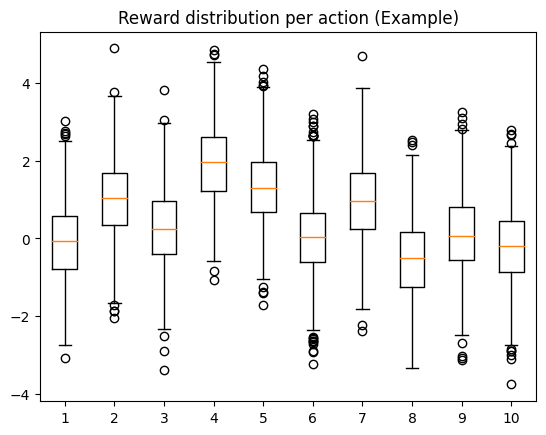

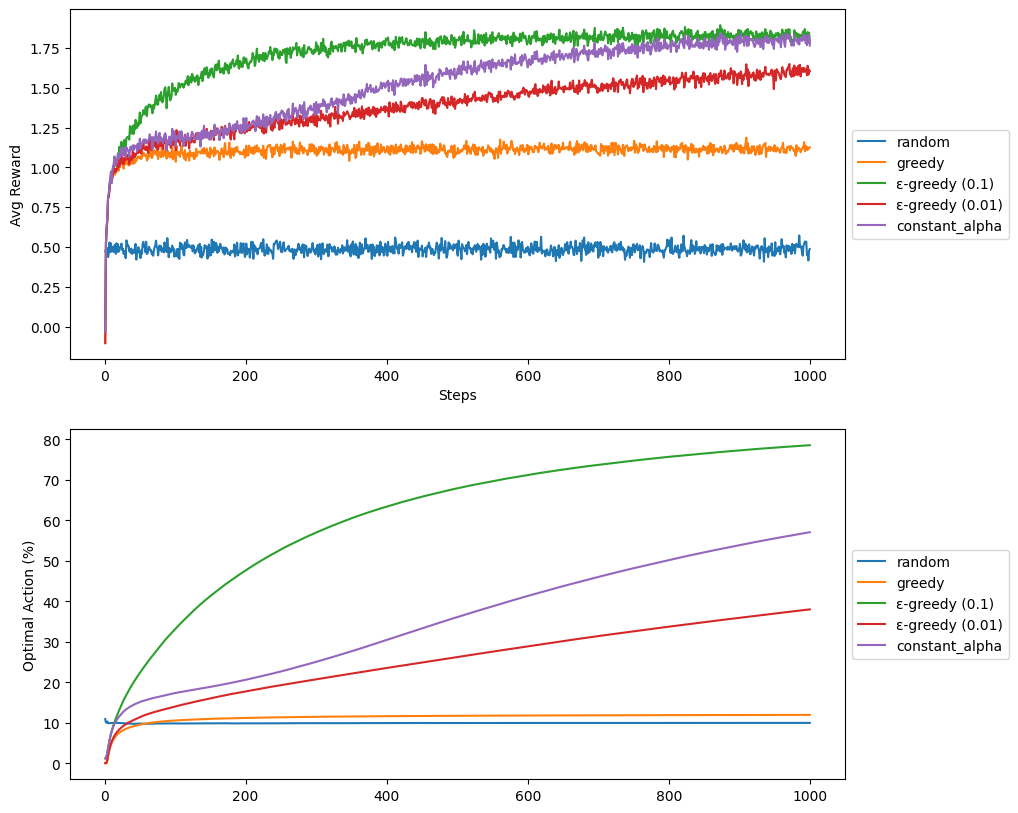

In [2]:
main(get_bandit=distributed_bandit(), parallel=2000, steps=1000, plot_rewards=True, cases=[
    Params(name='random', get_epsilon=lambda step: 1),
    Params(name='greedy', get_epsilon=lambda step: 0),
    Params(name='ε-greedy (0.1)', get_epsilon=lambda step: 0.1),
    Params(name='ε-greedy (0.01)', get_epsilon=lambda step: 0.01),
    Params(name='constant_alpha', get_epsilon=lambda step: 0.1, get_alpha=lambda step, n: 0.1),
])

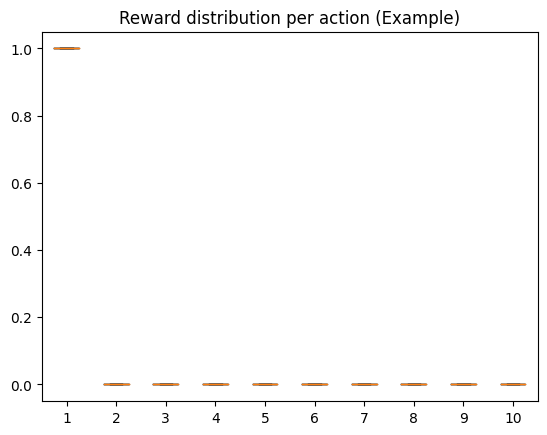

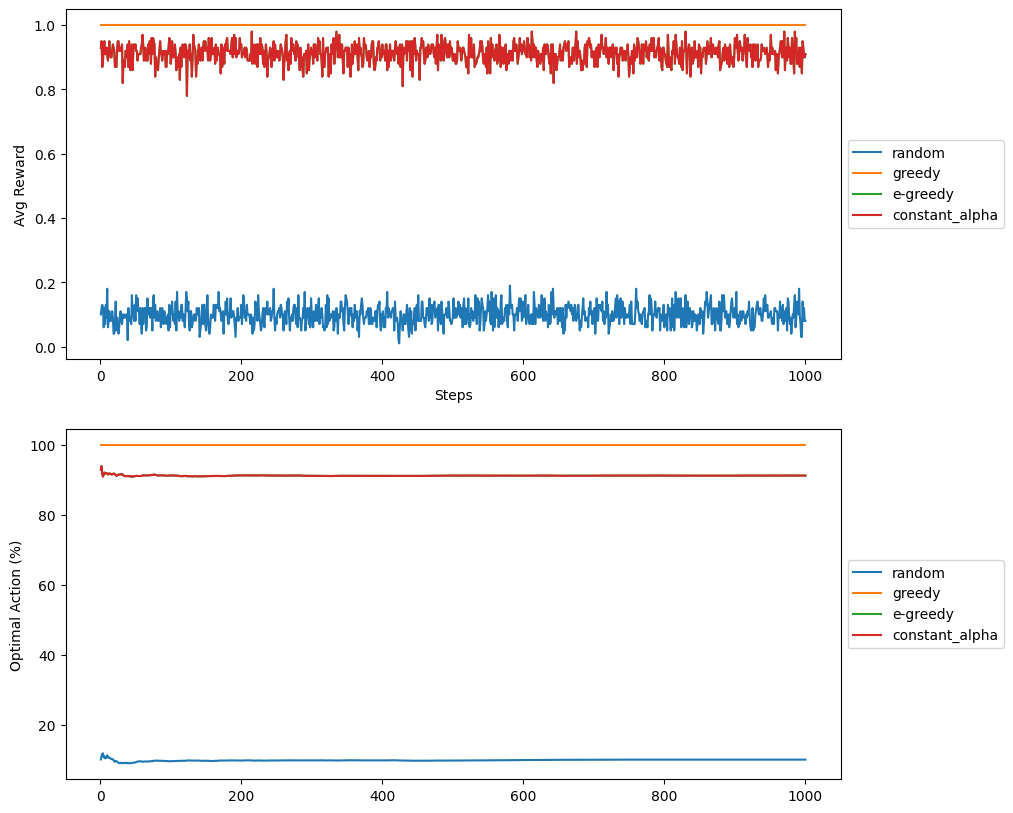

In [3]:
main(get_bandit=default_bandit, parallel=100, steps=1000, plot_rewards=True, cases=[
    Params(name='random', get_epsilon=lambda step: 1),
    Params(name='greedy', get_epsilon=lambda step: 0),
    Params(name='e-greedy', get_epsilon=lambda step: 0.1),
    Params(name='constant_alpha', get_epsilon=lambda step: 0.1, get_alpha=lambda step, n: 0.1),
])

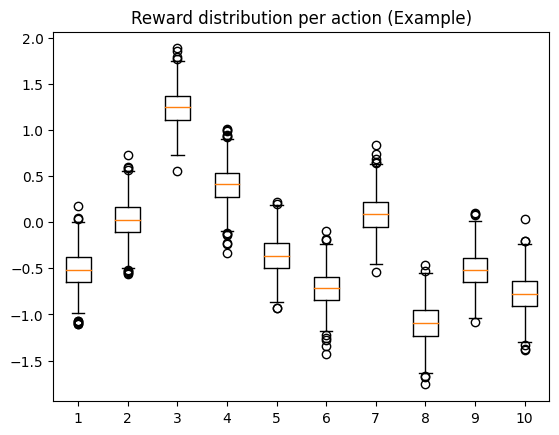

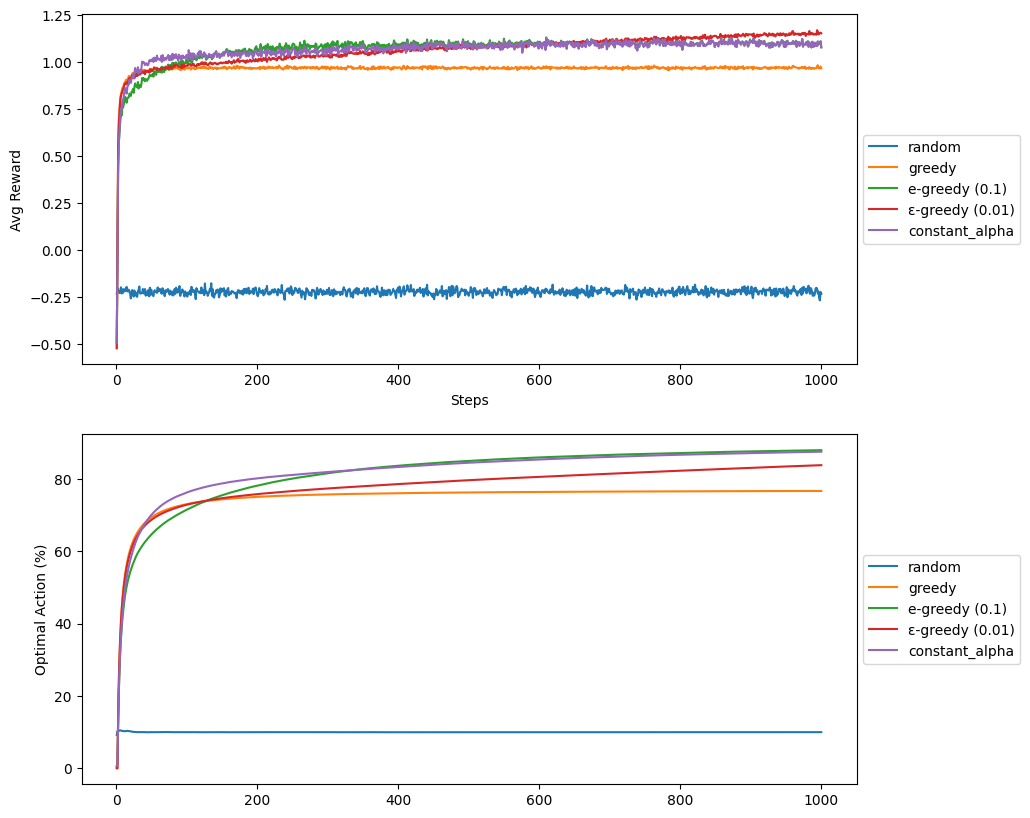

In [4]:
# consider the best action in each step, instead of a single best action overall
# defined with a lesser deviation per action, to more easily define the best action
main(get_bandit=distributed_bandit(dev_per_action=0.2), parallel=2000, steps=1000, best_action_per_step=True, plot_rewards=True, cases=[
    Params(name='random', get_epsilon=lambda step: 1),
    Params(name='greedy', get_epsilon=lambda step: 0),
    Params(name='e-greedy (0.1)', get_epsilon=lambda step: 0.1),
    Params(name='ε-greedy (0.01)', get_epsilon=lambda step: 0.01),
    Params(name='constant_alpha', get_epsilon=lambda step: 0.1, get_alpha=lambda step, n: 0.1),
])

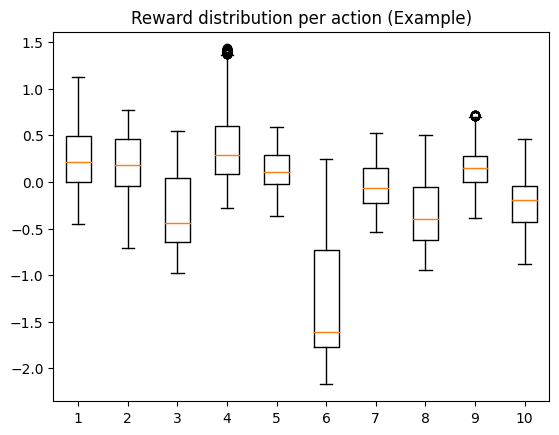

In [ ]:
# Exercise 2.5 (pg. 55)
main(get_bandit=non_stationary_bandit(), parallel=2000, steps=10000, plot_rewards=True, cases=[
    Params(name='sample_averages', get_epsilon=lambda step: 0.1),
    Params(name='constant_alpha', get_epsilon=lambda step: 0.1, get_alpha=lambda step, n: 0.1),
])

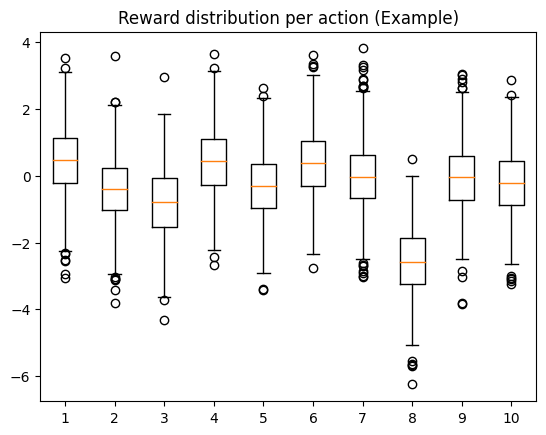

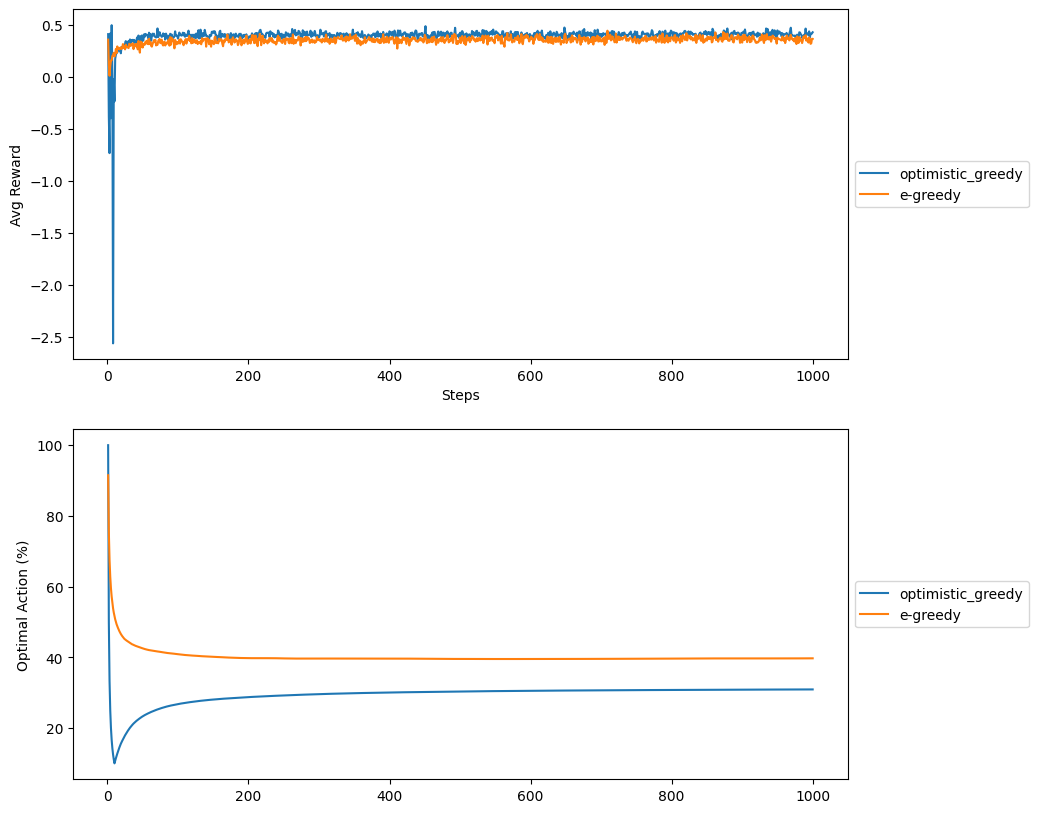

In [2]:
# initial_q=5
main(get_bandit=distributed_bandit(), parallel=2000, steps=1000, plot_rewards=True, cases=[
    Params(name='optimistic_greedy', get_epsilon=lambda step: 0, initial_q=5),
    Params(name='e-greedy', get_epsilon=lambda step: 0.1),
])

### Exercise 2.6: *Mysterious Spikes*

**Q**

The results shown in Figure 2.3 should be quite reliable because they are averages over 2000 individual, randomly chosen 10-armed bandit tasks. Why, then, are there oscillations and spikes in the early part of the curve for the optimistic method? In other words, what might make this method perform particularly better or worse, on average, on particular early steps?

**A**

Initially, it will explore all actions until all of them be more or less on the higher side of the best action, and from this point on it will choose the best action, but due to the stochasticity of the environment, the best (mean) action may give a bad reward in some time-step (which is almost guaranteed after several time-steps), which will decrease its value below the point where the others are, and the time it takes to reduce the value of the other actions may not be small, because at this point many actions may give rewards above the point in which the value of the best action is, and the agent is following a greedy policy, so while there is at least 1 action with higher value than the best action, it will continue to choose it. 

After the value of the best action becomes the highest again, as the steps go on, the value stabilizes at about its mean value (even if it receives a bad reward sometimes, the other actions were also chosen several times, so they will all be closer to their true values, and the updates will have less impact in the final value of each action).

This method perform particularly better when the overlap in the possible rewards of each action is small (being optimal if there's no overlap, in which case the best action will be chosen after each action is visited once, and will always be chosen from then on). It might be worse when there are good chances of overlap in the rewards (with good chances of making suboptimal actions give better rewards than the optimal action) due to its greedy nature, that will make the agent take more time to fix the mistake. In other words, the agent may temporarily prioritize suboptimal actions due to random reward fluctuations until the values stabilize.

### Exercise 2.7

In most of this chapter we have used sample averages to estimate action values because sample averages do not produce the initial bias that constant step sizes do (see the analysis in (2.6)). However, sample averages are not a completely satisfactory solution because they may perform poorly on non-stationary problems. Is it possible to avoid the bias of constant step sizes while retaining their advantages on non-stationary problems? One way is to use a step size of

$$
\beta_t \doteq \alpha / \overline{o}_t, \tag{2}
$$

where α > 0 is a conventional constant step size and $\overline{o}_t$ is a trace of one that starts at 0:

$$
\overline{o}_{t+1} = \overline{o}_t + \alpha(1 - \overline{o}_t), \tag{3}
$$

for t ≥ 1 and with $\overline{o}_1 = \alpha$.

Carry out an analysis like that in (2.6) to show that $\beta_t$ is an exponential recency-weighted average without initial bias.

\begin{align*}
\overline{o}_{n} &= \overline{o}_{n-1} + \alpha \cdot (1 - \overline{o}_{n-1}) \\
&=  \overline{o}_{n-1} + \alpha - \alpha \cdot \overline{o}_{n-1} \\
&=  \alpha + (1 - \alpha) \cdot \overline{o}_{n-1} \\
&=  \alpha + (1 - \alpha) \left( \alpha + (1 - \alpha) \cdot \overline{o}_{n-2} \right) \\
&=  \alpha + \alpha \cdot (1 - \alpha) + (1 - \alpha)^2 \cdot \overline{o}_{n-2} \\
&=  \alpha + \alpha \cdot (1 - \alpha) + (1 - \alpha) \left( (1 - \alpha) \cdot \overline{o}_{n-2} \right) \\
&...* \\
&= \alpha + \alpha \cdot (1 - \alpha) + \alpha \cdot (1 - \alpha)^2 + (1 - \alpha)^3 \cdot \overline{o}_{n-3} \\
&... \\
&= \alpha + \alpha \cdot (1 - \alpha) + \alpha \cdot (1 - \alpha)^2 + \alpha \cdot (1 - \alpha)^3 + \ldots + \alpha \cdot (1 - \alpha)^{n-1} + (1 - \alpha)^n \cdot \overline{o}_0 \\
&= \alpha + \alpha \cdot (1 - \alpha) + \alpha \cdot (1 - \alpha)^2 + \alpha \cdot (1 - \alpha)^3 + \ldots + \alpha \cdot (1 - \alpha)^{n-1} \\
&= \sum_{i=0}^{n-1} \alpha \cdot (1 - \alpha)^i
\end{align*}

\begin{align*}
*Obs: (1 - \alpha) \cdot \overline{o}_{n-1} \text{ became } \alpha \cdot (1 - \alpha) + (1 - \alpha)^2 \cdot \overline{o}_{n-2}, \\
\text{ so } (1 - \alpha) \cdot \overline{o}_{n-2} \text{ will become } \alpha \cdot (1 - \alpha) + (1 - \alpha)^2 \cdot \overline{o}_{n-3}
\end{align*}

\begin{equation}
\overline{o}_{n} = \sum_{i=0}^{n-1} \alpha \cdot (1 - \alpha)^i
\end{equation}

\begin{align*}
or
\end{align*}

\begin{equation}
\overline{o}_{n} = \alpha \cdot (1 - \alpha)^{n-1} + \overline{o}_{n-1}
\end{equation}

\begin{align*}
\text{this means that the most recent reward will have a slightly higher weight than the previous, and so on, }
\end{align*}

\begin{align*}
\text{but the increase of weight reduces exponentially with the number of steps}
\end{align*}

\begin{align*}
\text{so, } \beta_{n} = \alpha/\overline{o}_{n} \text{ will decrease with n, but very little due to the exponential nature of } \overline{o}_{n}
\end{align*}

\begin{align*}
\text{Also, } \overline{o}_{n} \text{ converges to 1 as n increases, according to the following:}
\end{align*}

\begin{align*}
\overline{o}_{n} &= \sum_{i=0}^{n-1} \alpha \cdot (1 - \alpha)^i \\
&= \alpha + \alpha \cdot (1 - \alpha) + \alpha \cdot (1 - \alpha)^2 + ... + \alpha \cdot (1 - \alpha)^{n-1}
\end{align*}

\begin{align*}
\text{so}
\end{align*}

\begin{align*}
\overline{o}_{n} - (1 - \alpha) \cdot \overline{o}_{n} = \alpha - \alpha \cdot (1 - \alpha)^n \\
\alpha \cdot \overline{o}_{n} = \alpha \cdot (1 - (1 - \alpha)^n) \\
\overline{o}_{n} = 1 - (1 - \alpha)^n
\end{align*}

\begin{align*}
\overline{o}_{n} \text{ increases each time less as n increases, converging to 1 as n goes to infinity, because } |1 - \alpha| < 1
\end{align*}

\begin{align*}
\text{Which means that } \beta_{n} = \alpha / \overline{o}_{n} \text{ starts with value } \beta_1 = 1 \text{ (} \overline{o}_{1} = \alpha \text{)}
\end{align*}

\begin{align*}
\text{and converges to } \alpha \text{ (} \overline{o}_{n} \text{ converges to 1, as explained above) as n goes to infinity, }
\end{align*}

\begin{align*}
\text{while sample averages starts with 1 and converges to 0 (because 1/n converges to 0)}
\end{align*}

\begin{align*}
\text{This means that using sample averages, the reward in later steps has almost no impact on } Q_n \text{,}
\end{align*}

\begin{align*}
\text{while using } \beta_n \text{, no matter how big is n, the current reward will still have a weight of at least } \alpha
\end{align*}

\begin{align*}
\text{Applying a reasoning similar to 2.6, we have:}
\end{align*}

\begin{align*}
Q_{n+1} &= Q_n + \beta_n \cdot [R_n - Q_n] \\
&= \beta_n \cdot R_n + (1 - \beta_n) \cdot Q_n \\
&= \beta_n \cdot R_n + (1 - \beta_n) \cdot [\beta_{n-1} \cdot R_{n-1} + (1 - \beta_{n-1}) \cdot Q_{n-1}] \\
&= \beta_n \cdot R_n + (1 - \beta_n) \cdot \beta_{n-1} \cdot R_{n-1} + (1 - \beta_n)(1 - \beta_{n-1}) \cdot Q_{n-1} \\
&= \beta_n \cdot R_n + (1 - \beta_n) \cdot \beta_{n-1} \cdot R_{n-1} + (1 - \beta_n)(1 - \beta_{n-1}) \cdot \beta_{n-2} \cdot R_{n-2} + \\
&... + [\prod_{i=2}^n (1 - \beta_i) ] \cdot \beta_1 \cdot R_1 + [\prod_{i=1}^n (1 - \beta_i) ] \cdot Q_1 \\
&= [\prod_{i=1}^n (1 - \beta_i) ] \cdot Q_1 + \sum_{i=1}^n [\prod_{j=i+1}^n (1 - \beta_j) ] \cdot \beta_i \cdot R_i
\end{align*}

\begin{align*}
\text{with } \prod_{j=k}^n (1 - \beta_j) = 1 \text{ if } k > n \text{ (Empty Product Convention)}
\end{align*}

\begin{align*}
\text{but } \beta_1 = 1 \text{ (as said above) and, consequently, } 1 - \beta_1 = 0 \text{, so:}
\end{align*}

\begin{align*}
Q_{n+1} = \sum_{i=1}^n [\prod_{j=i+1}^n (1 - \beta_j) ] \cdot \beta_i \cdot R_i
\end{align*}

\begin{align*}
\text{which does not have an initial bias (does not depend on } Q_1 \text{)}
\end{align*}

\begin{align*}
\text{It's important to note that the sum of the weights is 1, that is:}
\end{align*}

\begin{align*}
f(n) = \sum_{i=1}^n [\prod_{j=i+1}^n (1 - \beta_j) ] \cdot \beta_i = 1
\end{align*}

\begin{align*}
\text{because for a value of n, the next function value is the previous multiplied by }(1 - \beta_{n+1})
\end{align*}

\begin{align*}
\text{ and added the new weight, the last, which is }\beta_{n+1}\text{:}
\end{align*}

\begin{align*}
f(n+1) &= \sum_{i=1}^{n+1} [\prod_{j=i+1}^{n+1} (1 - \beta_j) ] \cdot \beta_i \\
&= \left[ \left[\prod_{j=n+1+1}^{n+1} (1 - \beta_j) \right] \cdot \beta_{n+1} \right] + \left[\sum_{i=1}^n \left[\prod_{j=i+1}^{n+1} (1 - \beta_j) \right] \cdot \beta_i \right] \\
&= \left[ 1 \cdot \beta_{n+1} \right] + \left[\sum_{i=1}^n (1 - \beta_{n+1}) \left[\prod_{j=i+1}^n (1 - \beta_j) \right] \cdot \beta_i \right] \\
&= \beta_{n+1} + (1 - \beta_{n+1}) \left[\sum_{i=1}^n \left[\prod_{j=i+1}^n (1 - \beta_j) \right] \cdot \beta_i \right] \\
&= \beta_{n+1} + (1 - \beta_{n+1}) f(n) \\
&= 1 + \beta_{n+1} (1 - f(n))
\end{align*}

\begin{align*}
\text{For a value of n such as f(n) = 1, the next term is 1:}
\end{align*}

\begin{align*}
f(n+1) = 1 + \beta_{n+1} (1 - f(n)) = 1 + \beta_{n+1} (1 - 1) = 1, \quad \text{given f(n) = 1}
\end{align*}

\begin{align*}
\text{Also, f(1) = 1:}
\end{align*}

\begin{align*}
f(1) = \sum_{i=1}^1 [\prod_{j=i+1}^1 (1 - \beta_j) ] \cdot \beta_i = [\prod_{j=1+1}^1 (1 - \beta_j) ] \cdot \beta_1 = 1 \cdot \beta_1 = \beta_1 = 1
\end{align*}

\begin{align*}
\text{And taking into account that f(n+1) = 1 if f(n) = 1, then f(n) = 1 for all n > 1}
\end{align*}

\begin{align*}
\text{(f(1) = 1 implies f(2) = 1, which implies f(3) = 1, and so on)}
\end{align*}

\begin{align*}
\text{so the sum of the weights are 1 for any number of terms n in the sum.}
\end{align*}

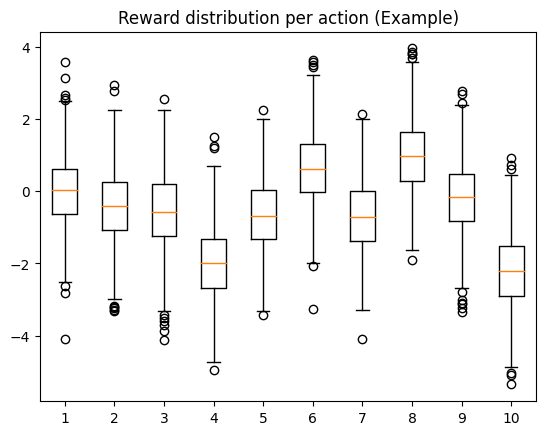

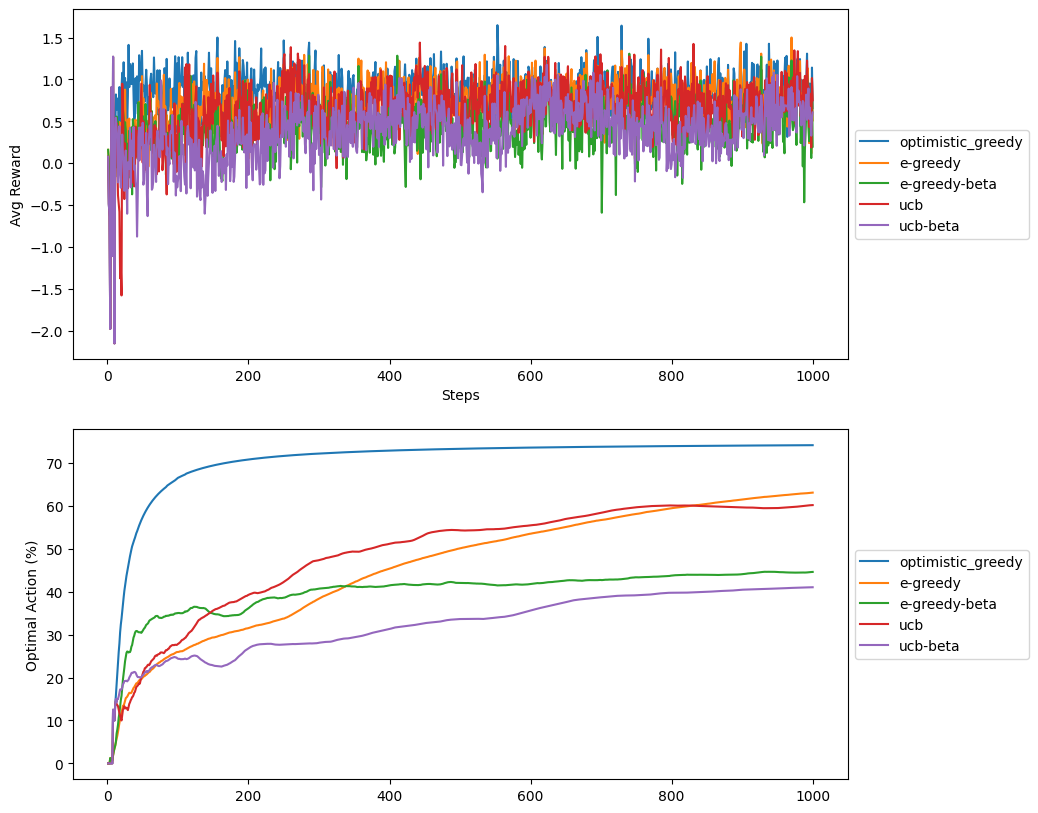

In [3]:
# [section 2.7] Upper-Confidence-Bound Action Selection
main(get_bandit=distributed_bandit(), parallel=20, steps=1000, plot_rewards=True, cases=[
    Params(name='optimistic_greedy', get_epsilon=lambda step: 0, initial_q=5),
    Params(name='e-greedy', get_epsilon=lambda step: 0.1),
    Params(name='e-greedy-beta', get_epsilon=lambda step: 0.1, get_beta=default_beta),
    Params(name='ucb', ucb_c=2),
    Params(name='ucb-beta', ucb_c=2, get_beta=default_beta),
])

### Exercise 2.8: *UCB Spikes*

**Q**

In Figure 2.4 the UCB algorithm shows a distinct spike in performance on the 11th step. Why is this? Note that for your answer to be fully satisfactory it must explain both why the reward increases on the 11th step and why it decreases on the subsequent steps. Hint: If c = 1, then the spike is less prominent. 

**A**

There are 10 different actions that the agent can choose, so the first 10 time-steps will each have a different action chosen because there will be an action $a$ in which $N(a) = 0$ in each of these time-steps. In the 11th step, the term $c\sqrt{\frac{ln{t}}{N_t(a)}}$, that corresponds to the confidence in the precision of its value due to the amount of times the action was chosen according to UCB (less confidence will give higher values to explore more), is the same for all actions ($t$ is $11$ in this case, $N_{11}(a) = 1$ for every action). This mean that the action that gave the best reward in the first 10 time-steps will be chosen.

The graph shows the average performance of UCB action selection among several executions in parallel. The action with best reward in those executions is found between the 1st and 10th time-steps in each run, but it will not be the same across a sufficient number of runs with different seeds, so the average performance should be about 0 (because the mean reward of the actions is 0). On the 11th time-step, tough, the action with the best reward will be chosen in each parallel execution, due to the reason explained previously, so there will be a significant increase in value between the 10th and 11th average performance. At this point, the value may not still be the optimal value: some executions will choose non-optimal actions because the action that have given the best reward in the first 10 time-steps may not be the best action due to the stochasticity of the environment (if the standard deviation of each action was 0, then the environment would be deterministic, but this is the case). As new actions are chosen across many time-steps, the agent will start choosing the actual best actions (the ones with the best mean). This can be seen as the spike in the 11th time-step has an average reward of about 1, but in later time-steps it approaches 1.5. That said, the action chosen by each agent for the 11th time-step should be a good action in most cases, so the average reward at this time-step is not so bad.

The reason for the fast decrease in value right after the 11th time-step is that at this point the term $c\sqrt{\frac{ln{t}}{N_t(a)}}$ for the best action will be less than the other actions by a factor of $\frac{1}{\sqrt{2}}$, with the possibility of choosing the other actions depending on how big this value is when compared to the current values of those actions. For example, at time-step 16, considering that the best action of the first 10 time-steps was not chosen gain after time-step 11, the value of this term will be:

For the best action: 

$$
c\sqrt{\frac{ln{t}}{N_t(a)}} = 2\sqrt{\frac{16}{2}} = 2\sqrt{8} = 4\sqrt{2} \approx 5.6
$$

For all actions that were chosen only once:

$$
c\sqrt{\frac{ln{t}}{N_t(a)}} = 2\sqrt{\frac{16}{1}} = 2 \cdot 4 = 8
$$

The mean among all actions is 0, the standard deviation to define the mean of each action is 1, and for each action, the standard deviation of the actual value is also 1, so it's expected that the best action will not have a value higher than 1.5, and the worse action probably will not have a value lower than -1.5, so their difference in values will probably be less than 3, with many actions with much less difference. The difference of the 2nd term used to choose the action is 2.4 (8 - 5.6), so it's very likely that the algorithm will iterate all over the actions again, or at least iterate among most of them, after step 11, causing the decrease in reward. From now on, the 2nd term will have each time less impact on the overall UCB value to choose the action, because t is in a logarithm and will not increase so much for larger values of t.

A value of $c = 1$ just makes the process of making the 2nd term have less impact faster:

For the best action: 

$$
c\sqrt{\frac{ln{t}}{N_t(a)}} = \sqrt{\frac{16}{2}} = \sqrt{8} = 2\sqrt{2} \approx 2.8
$$

For all actions that were chosen only once:

$$
c\sqrt{\frac{ln{t}}{N_t(a)}} = \sqrt{\frac{16}{1}} = 4
$$

The difference is 1.2 (4 - 2.8), so it's very likely that only a few other actions with good rewards will be chosen after the 11th step, while the worst actions (that probably won't be the action with the actual best mean) will take some time to be chosen again, making the spike less prominent.

### Exercise 2.9

The sigmoid function is defined as:

\begin{align*}
σ(x) = \frac{1}{1 + e^{-x}}
\end{align*}

The softmax distribution of action probabilities is defined as:

\begin{align*}
Pr\{A_t=a\} = \pi_t(a) = \frac{e^{H_t(a)}}{\sum_{b=1}^k e^{H_t(b)}}
\end{align*}

In the case of 2 actions `a=1` and `b=2`, we have the softmax function:

\begin{align*}
Pr\{A_t=a\} = \pi_t(a) = \frac{e^{H_t(a)}}{\sum_{i=1}^2 e^{H_t(i)}} = \frac{e^{H_t(a)}}{e^{H_t(a)} + e^{H_t(b)}} = \frac{1}{1 + \frac{e^{H_t(b)}}{e^{H_t(a)}}} = \frac{1}{1 + e^{{H_t(b)} - {H_t(a)}}}
\end{align*}

So we have: 

\begin{align*}
\pi_t(a) = \frac{1}{1 + e^{- ({H_t(a)} - {H_t(b)})}}
\end{align*}

Which means that the softmax function with 2 actions, `a` and `b`, is the same as the sigmoid function:

\begin{align*}
\pi_t(a) = σ({H_t(a)} - {H_t(b)})
\end{align*}

Where ${H_t(a)} - {H_t(b)}$ is the relative preference of `a` over `b`.

And correspondingly:

\begin{align*}
\pi_t(b) = σ({H_t(b)} - {H_t(a)})
\end{align*}

It's also important to note that the sum of the probabilities for all actions is always 1 (for any number of actions, not only for the specific case of 2 actions):

\begin{align*}
\sum_{a=1}^k \pi_t(a) = \sum_{a=1}^k \frac{e^{H_t(a)}}{\sum_{b=1}^k e^{H_t(b)}} = \frac{\sum_{a=1}^k e^{H_t(a)}}{\sum_{b=1}^k e^{H_t(b)}} = 1
\end{align*}



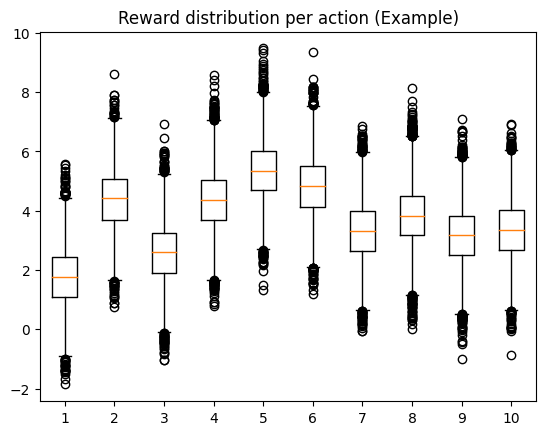

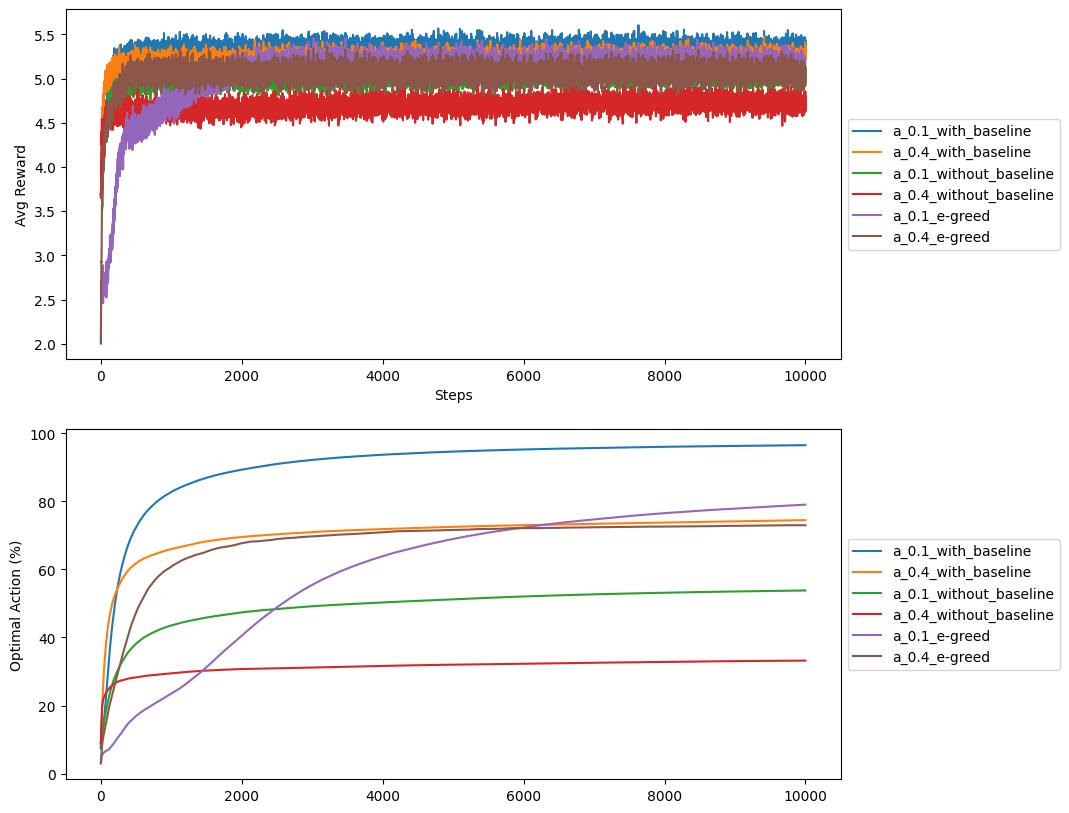

In [4]:
# [section 2.8] Gradient Bandit Algorithms
main(get_bandit=distributed_bandit(mean=4, deviation=1), parallel=200, steps=10000, plot_rewards=True, cases=[
    Params(name='a_0.1_with_baseline', get_epsilon=no_epsilon, get_alpha=fixed_alpha(0.1), preference=True),
    Params(name='a_0.4_with_baseline', get_epsilon=no_epsilon, get_alpha=fixed_alpha(0.4), preference=True),
    Params(name='a_0.1_without_baseline', get_epsilon=no_epsilon, get_alpha=fixed_alpha(0.1), preference=True, no_pref_baseline=True),
    Params(name='a_0.4_without_baseline', get_epsilon=no_epsilon, get_alpha=fixed_alpha(0.4), preference=True, no_pref_baseline=True),
    Params(name='a_0.1_e-greed', get_epsilon=fixed_epsilon(0.1), get_alpha=fixed_alpha(0.1)),
    Params(name='a_0.4_e-greed', get_epsilon=fixed_epsilon(0.1), get_alpha=fixed_alpha(0.4)),
])

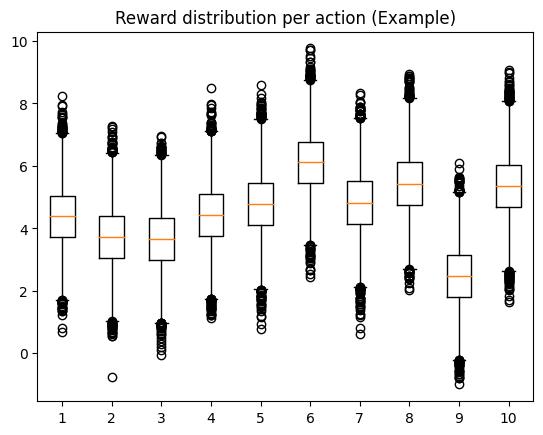

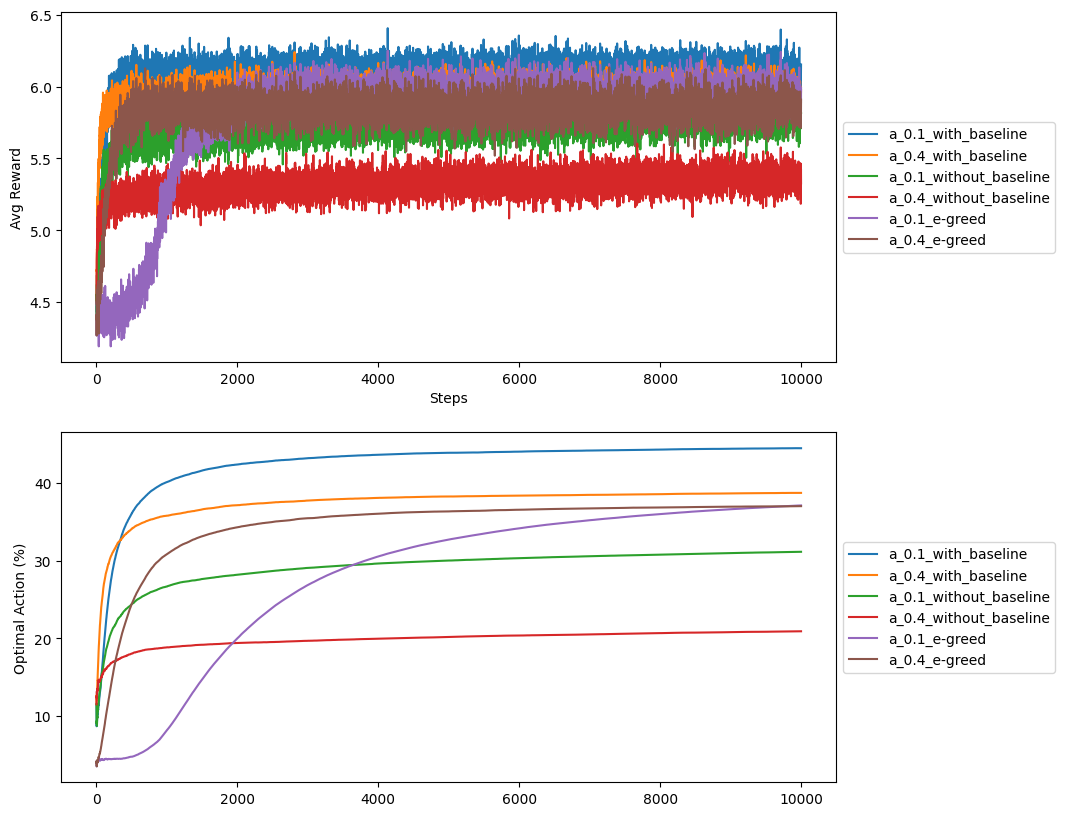

In [5]:
# [section 2.8] Gradient Bandit Algorithms (considering the best action per step, instead of the best average for all steps)
main(get_bandit=distributed_bandit(mean=4, deviation=1), parallel=200, steps=10000, best_action_per_step=True, plot_rewards=True, cases=[
    Params(name='a_0.1_with_baseline', get_epsilon=no_epsilon, get_alpha=fixed_alpha(0.1), preference=True),
    Params(name='a_0.4_with_baseline', get_epsilon=no_epsilon, get_alpha=fixed_alpha(0.4), preference=True),
    Params(name='a_0.1_without_baseline', get_epsilon=no_epsilon, get_alpha=fixed_alpha(0.1), preference=True, no_pref_baseline=True),
    Params(name='a_0.4_without_baseline', get_epsilon=no_epsilon, get_alpha=fixed_alpha(0.4), preference=True, no_pref_baseline=True),
    Params(name='a_0.1_e-greed', get_epsilon=fixed_epsilon(0.1), get_alpha=fixed_alpha(0.1)),
    Params(name='a_0.4_e-greed', get_epsilon=fixed_epsilon(0.1), get_alpha=fixed_alpha(0.4)),
])

### Exercise 2.10

**Q**

Suppose you face a 2-armed bandit task whose true action values change randomly from time step to time step. Specifically, suppose that, for any time step, the true values of actions 1 and 2 are respectively 0.1 and 0.2 with probability 0.5 (case A), and 0.9 and 0.8 with probability 0.5 (case B). If you are not able to tell which case you face at any step, what is the best expectation of success you can achieve and how should you behave to achieve it? Now suppose that on each step you are told whether you are facing case A or case B (although you still don’t know the true action values). This is an associative search task. What is the best expectation of success you can achieve in this task, and how should you behave to achieve it?

**A**

If you don't know the case, the expectation of choosing the same case is:

For action 1: $0.5 \cdot 0.1 + 0.5 \cdot 0.9 = 0.5$ (0.5 probability of case A and 0.5 probability of case B)

For action 2: $0.5 \cdot 0.2 + 0.5 \cdot 0.8 = 0.5$ (0.5 probability of case A and 0.5 probability of case B)

This means that for each action, if you don't know which case is, the expectation is 0.5, no matter which action you choose.

In the case in which you know which case it is (A or B), then:

If the case is A, choose the best action: action 2, that has true value 0.2

If the case is B, choose the best action: action 1, that has true value 0.9

As each of the 2 cases have a probability of 0.5 of happening, the expectation (mean value across a large number of steps) will be: $0.5 \cdot 0.2 + 0.5 \cdot 0.9 = 0.55$

### Exercise 2.11 (programming)

**Q**

Make a figure analogous to Figure 2.6 for the nonstationary case outlined in Exercise 2.5. Include the constant-step-size $\epsilon$-greedy algorithm with $\alpha$=0.1. Use runs of 200,000 steps and, as a performance measure for each algorithm and parameter setting, use the average reward over the last 100,000 steps.

**A**

In [ ]:
# Exercise 2.11 (pg. 66)
verify_params(
    parallel=10,
    steps=200 * 10**3,
    consider_last=100 * 10**3,
    get_bandit=non_stationary_bandit(),
    plot_rewards=True,
    plot_cases=True,
    cases_params=[
        CaseParams(
            name='epsilon',
            params_list=exponential_params(-7, -2),
            get_case=lambda epsilon: Params(name=f'epsilon={epsilon}', get_epsilon=fixed_epsilon(epsilon)),
            color='red',
        ),
        CaseParams(
            name='gradient',
            params_list=exponential_params(-5, 2),
            get_case=lambda alpha: Params(name=f'gradient={alpha}', preference=True, get_alpha=fixed_alpha(alpha)),
            color='green',
        ),
        CaseParams(
            name='ucb',
            params_list=exponential_params(-4, 2),
            get_case=lambda ucb_c: Params(name=f'ucb={ucb_c}', ucb_c=ucb_c),
            color='blue',
        ),
        CaseParams(
            name='optimistic',
            params_list=exponential_params(-2, 2),
            get_case=lambda initial_q: Params(name=f'optimistic={initial_q}', get_alpha=fixed_alpha(0.1), initial_q=initial_q),
            color='black',
        ),
    ],
)

In [ ]:
# Exercise 2.11 (pg. 66) (with best action per step, instead of the best average reward per step)
verify_params(
    parallel=10,
    steps=200 * 10**3,
    consider_last=100 * 10**3,
    get_bandit=non_stationary_bandit(),
    best_action_per_step=True,
    plot_rewards=True,
    plot_cases=True,
    cases_params=[
        CaseParams(
            name='epsilon',
            params_list=exponential_params(-7, -2),
            get_case=lambda epsilon: Params(name=f'epsilon={epsilon}', get_epsilon=fixed_epsilon(epsilon)),
            color='red',
        ),
        CaseParams(
            name='gradient',
            params_list=exponential_params(-5, 2),
            get_case=lambda alpha: Params(name=f'gradient={alpha}', preference=True, get_alpha=fixed_alpha(alpha)),
            color='green',
        ),
        CaseParams(
            name='ucb',
            params_list=exponential_params(-4, 2),
            get_case=lambda ucb_c: Params(name=f'ucb={ucb_c}', ucb_c=ucb_c),
            color='blue',
        ),
        CaseParams(
            name='optimistic',
            params_list=exponential_params(-2, 2),
            get_case=lambda initial_q: Params(name=f'optimistic={initial_q}', get_alpha=fixed_alpha(0.1), initial_q=initial_q),
            color='black',
        ),
    ],
)

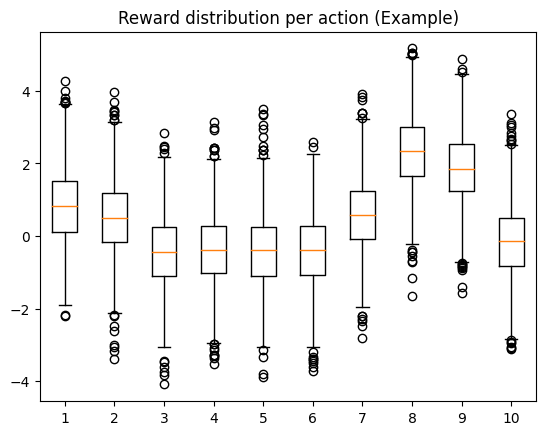

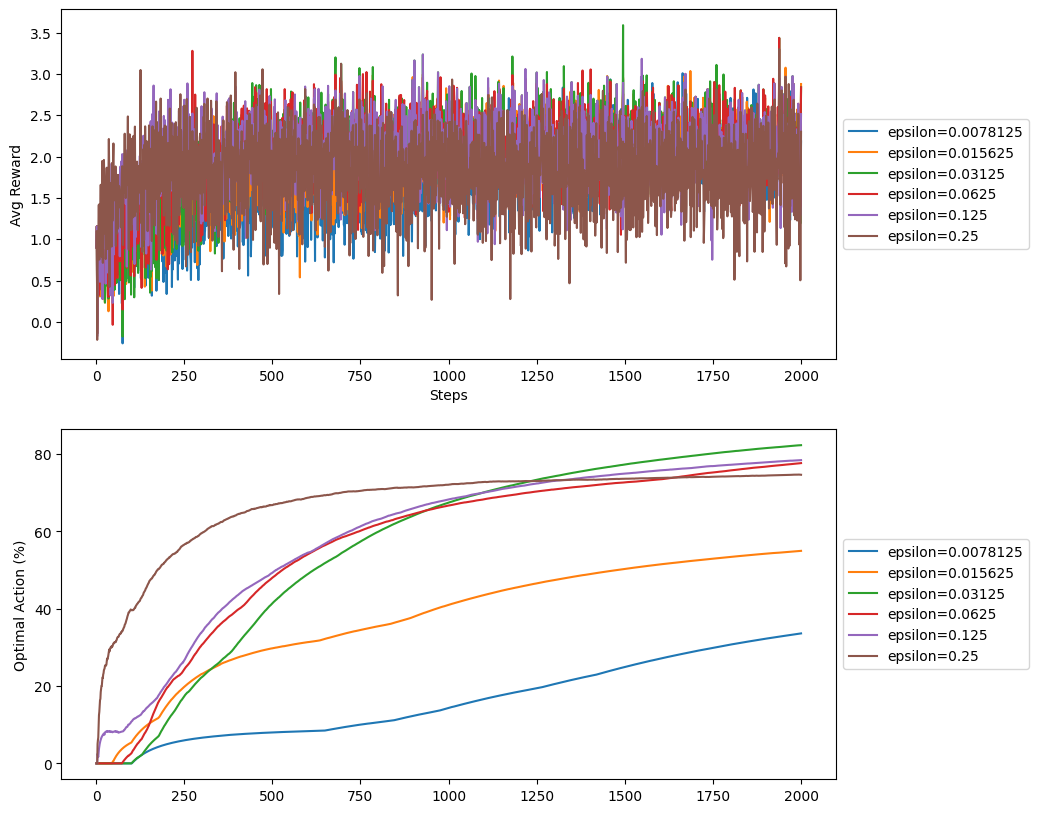

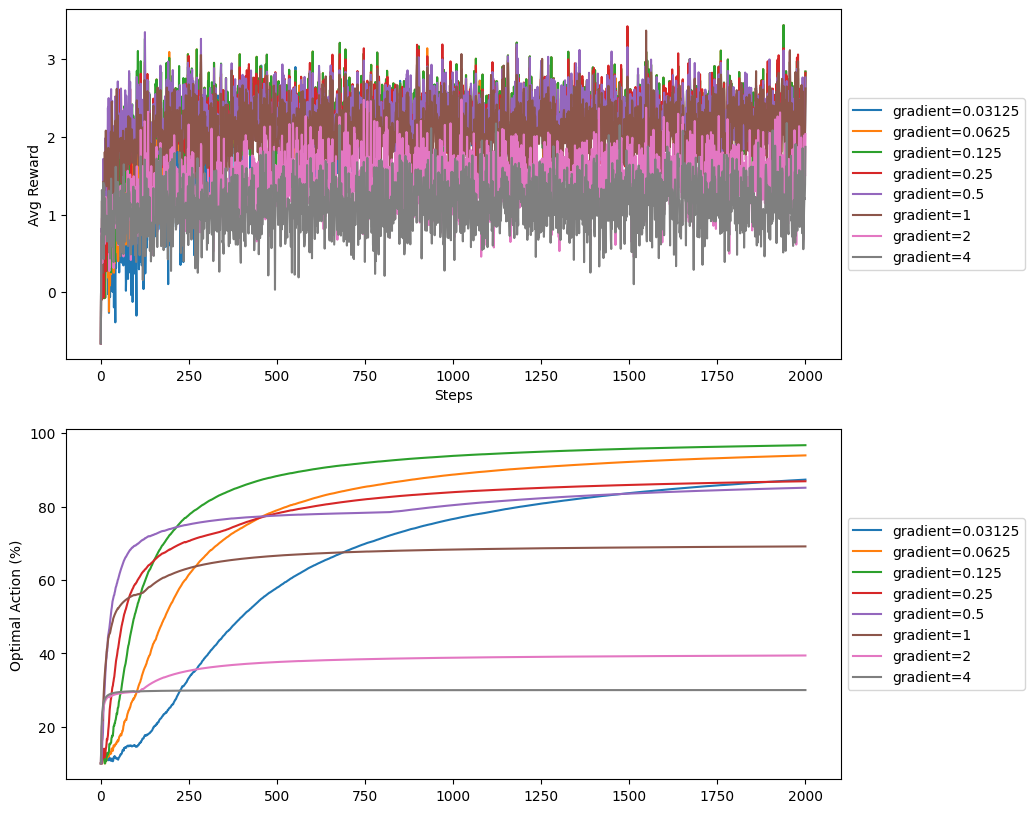

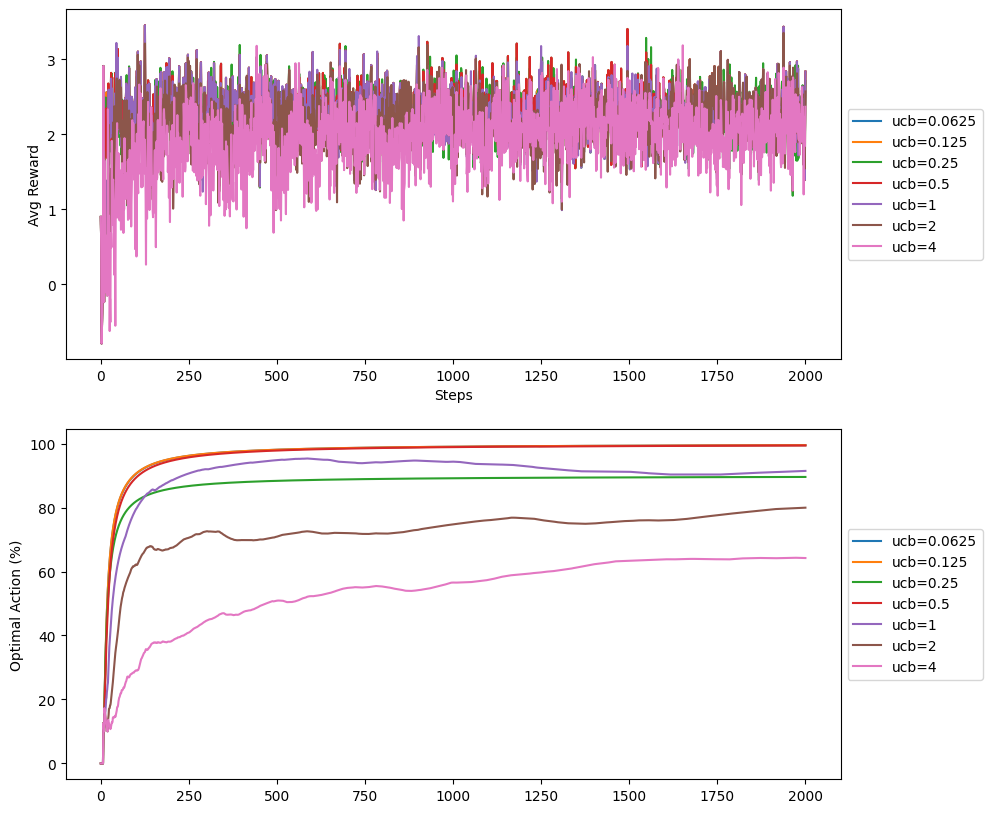

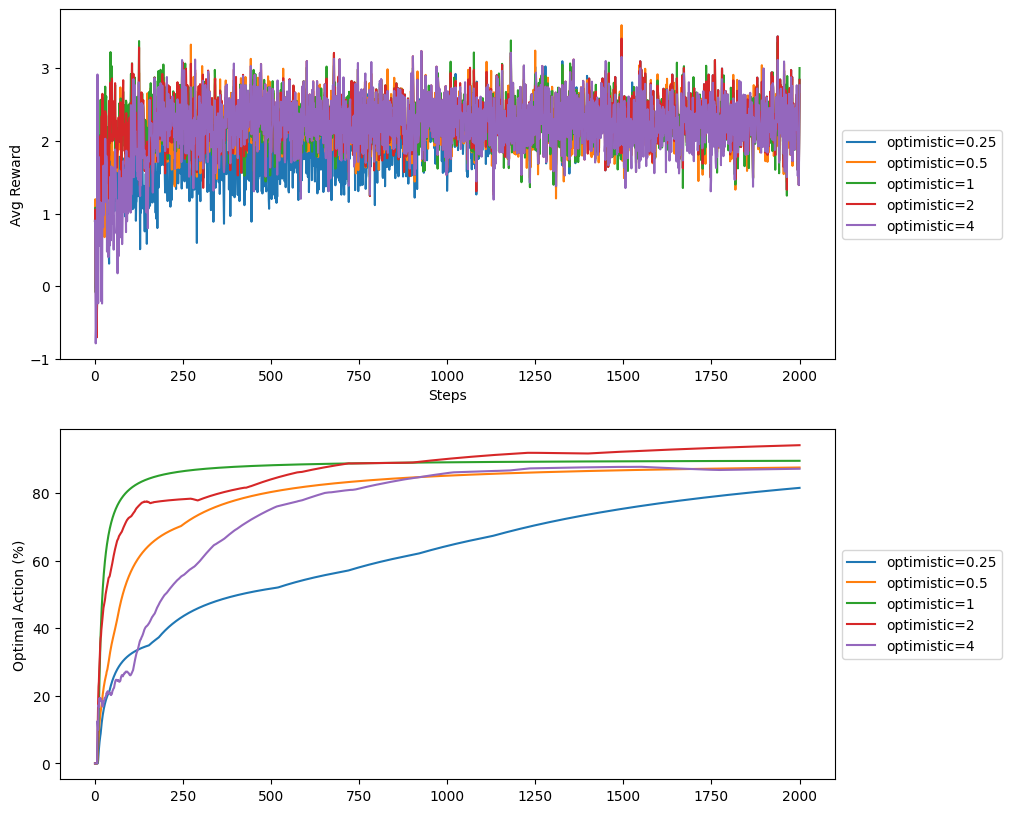

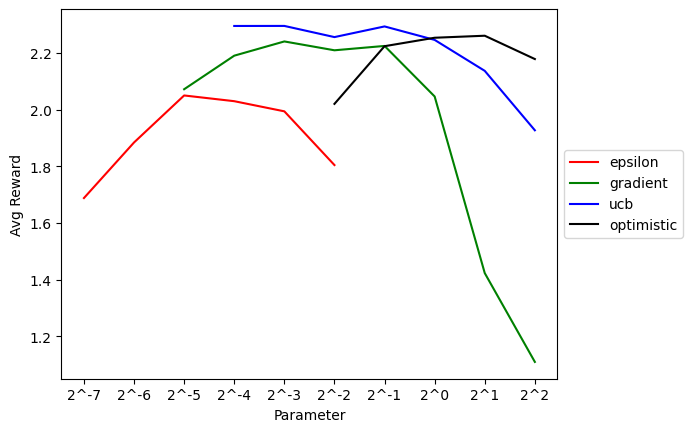

In [3]:
verify_params(
    parallel=10,
    steps=2 * 10**3,
    consider_last=1 * 10**3,
    get_bandit=distributed_bandit(mean=0, deviation=1),
    plot_rewards=True,
    plot_cases=True,
    cases_params=[
        CaseParams(
            name='epsilon',
            params_list=exponential_params(-7, -2),
            get_case=lambda epsilon: Params(name=f'epsilon={epsilon}', get_epsilon=fixed_epsilon(epsilon)),
            color='red',
        ),
        CaseParams(
            name='gradient',
            params_list=exponential_params(-5, 2),
            get_case=lambda alpha: Params(name=f'gradient={alpha}', preference=True, get_alpha=fixed_alpha(alpha)),
            color='green',
        ),
        CaseParams(
            name='ucb',
            params_list=exponential_params(-4, 2),
            get_case=lambda ucb_c: Params(name=f'ucb={ucb_c}', ucb_c=ucb_c),
            color='blue',
        ),
        CaseParams(
            name='optimistic',
            params_list=exponential_params(-2, 2),
            get_case=lambda initial_q: Params(name=f'optimistic={initial_q}', get_alpha=fixed_alpha(0.1), initial_q=initial_q),
            color='black',
        ),
    ],
)